## GANs
---
Generative adversarial networks are a set of deep neural network models, introduced in 2014, used to generate synthetic data. GANs have been used in a wide variety of tasks including improving astronomical images, up-scaling resolution of old video games, and the most well known application, ‘deepfakes’ which involve human image synthesis.
Sure, GANs has it's huge percs, but one of the negative points that will be pointed out during tha model creation, no matter the project to work on, is the time to take to train the model. It will take houdreads or thousands of epochs, depending on your model, to have an output which will have even a slight similarity to the input image. 

---
### Abstract Art choice
Art is beautiful and unique. Abstract art is non-understandable at first but then one tries to find signification to every trait of the peinture. The choice of working on abstract art dataset has it's percs that, no matter the quality, it will still be considered as something bizarre, which means that the model may be trained with little time, with considerable small epochs. This jupyter notebook is a small portion of what can be done with the dataset, and myself being not specialized in the GANz domain, I chose to have at least 1 work dedicated to this topic.


In [1]:
try:
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import warnings

    import PIL
    from PIL import Image

    from sklearn.cluster import KMeans

    import tensorflow  as tf
    from tensorflow.keras import layers
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization, Conv2DTranspose
    from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
    #from tensorflow.keras.optimizers import Adam
    print('All libraries are in place')
    
except:
    raise Exception("Library/ies not found, install by using pip command")


plt.style.use('dark_background')
warnings.filterwarnings("ignore")

All libraries are in place


---
## Initialization and familiarization with data
---

In [2]:
PATH = 'path/to/gallery'
BATCH = 64
IMG_SIZE = (64,64)
LATENT_DIM = 100
EPOCHS = 777

batch_s = int(BATCH/2)
#Import as tf.Dataset
gallery = tf.keras.preprocessing.image_dataset_from_directory(PATH, label_mode = None, 
                                                           image_size = IMG_SIZE, batch_size = batch_s).map(lambda x: x /255.0)

Found 2782 files belonging to 1 classes.


2023-02-18 15:11:31.103388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-18 15:11:31.104343: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-18 15:11:31.333353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-18 15:11:31.334591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-18 15:11:31.336006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

2023-02-18 15:11:36.202067: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


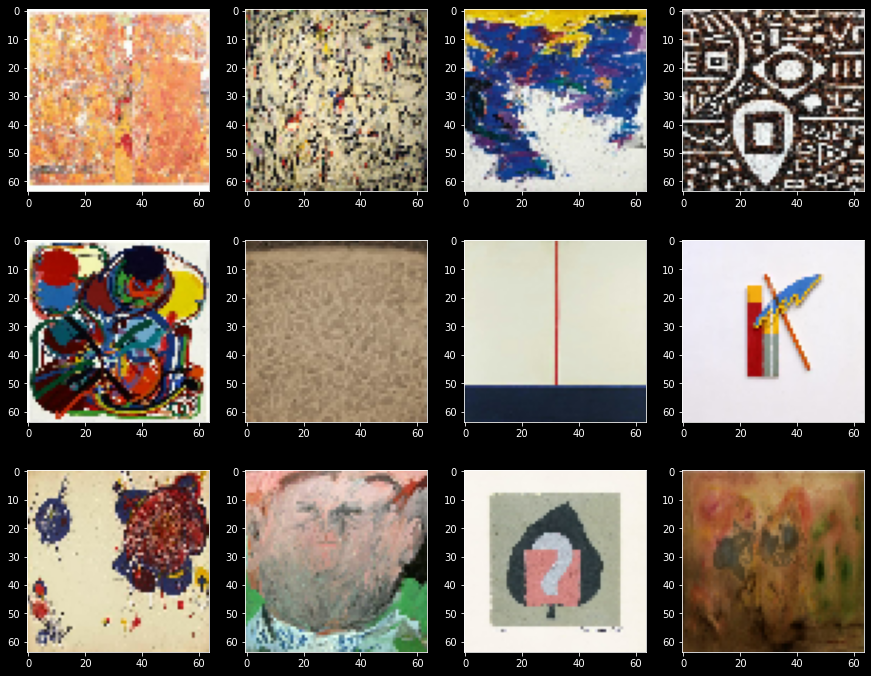

In [3]:
for some_of in gallery:
    break
f,ax = plt.subplots(3,4 ,figsize=(15,12))
ax=ax.flatten()
for i in range(12):
    ax[i].imshow(some_of[i])
#Low resolution, abstract images 64x64

---
## Definition of Generator and Discriminator
---
### Genearator

The generator accepts a random 1D array (here, 100). The first dense layer expands the input and the subsequent reshape layer transforms it to a 3D tensor. Then, the 3D tensor passes into multiple transposed 2D convolutional layers, before finally transforming into 64x64 image with RGB correction. In the same convolutional network, it goes by batch normaization and LeakyReLU layers.

In [4]:
class Generator(Sequential):
    def __init__(self, input_shape: int, *args, **kwargs):
        super().__init__()
        self.add(Dense(4*4*512, input_shape=input_shape))
        self.add(Reshape([4, 4, 512]))
        for i in range(3):
            self.add(Conv2DTranspose(256/(2 ** i), kernel_size=4, strides=2, padding='same'))
            self.add(LeakyReLU(alpha=0.2))
            self.add(BatchNormalization())
        self.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation='sigmoid'))

        
generator_ganz = Generator(input_shape=[LATENT_DIM])
generator_ganz.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              827392    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         2097408   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       524416    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0 

---
### Discriminator

The discriminator accepts an input image and identifies if it's a real portrait. It consists of multiple convolutional layers followed by a dense layer and functions like a basic CNN classfier. Finally it assigns each image a score depending on how close they seem to have come from the real data distribution. This discriminator does not consist of any pooling layers.

In [5]:
class Discriminator(Sequential):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.add(Conv2D(32, kernel_size=4, strides=2, padding="same",input_shape=[64,64, 3]))
        self.add(Conv2D(64, kernel_size=4, strides=2, padding="same"))
        self.add(LeakyReLU(0.2))
        self.add(BatchNormalization())
        self.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
        self.add(LeakyReLU(0.2))
        self.add(BatchNormalization())
        self.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
        self.add(LeakyReLU(0.2))
        self.add(Flatten())
        self.add(Dropout(0.5))
        self.add(Dense(1,activation='sigmoid'))


discriminator_ganz = Discriminator()
discriminator_ganz.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        1568      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        32832     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)       

---
## Training Gan
---

In [6]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim, *args, **kwargs):
        super(GAN, self).__init__(*args, **kwargs)
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(noise)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            dloss = self.loss_fn(labels, predictions)
        grads = tape.gradient(dloss, self.discriminator.trainable_weights)
        self.d_opt.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        noise = tf.random.normal(shape=(2*batch_size, self.latent_dim))
        labels = tf.zeros((2*batch_size, 1))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(noise))
            gloss = self.loss_fn(labels, predictions)
        grads = tape.gradient(gloss, self.generator.trainable_weights)
        self.g_opt.apply_gradients(zip(grads, self.generator.trainable_weights))
        self.dloss.update_state(dloss)
        self.gloss.update_state(gloss)
        return {"d_loss": self.dloss.result(), "g_loss": self.gloss.result()}

    def compile(self, d_opt, g_opt, loss_fn):
        super(GAN, self).compile()
        self.d_opt = d_opt
        self.g_opt = g_opt
        self.loss_fn = loss_fn
        self.dloss = tf.keras.metrics.Mean(name="discrim_loss")
        self.gloss = tf.keras.metrics.Mean(name="gen_loss")
        
    @property
    def metrics(self):
        return [self.dloss, self.gloss]

   

In [7]:
discriminator_opt = tf.keras.optimizers.Adam(1.5e-5,0.5)
generator_opt = tf.keras.optimizers.Adam(1.5e-5,0.5)
loss_fn = tf.keras.losses.BinaryCrossentropy()
model = GAN(discriminator=discriminator_ganz, generator=generator_ganz, latent_dim=LATENT_DIM)
model.compile(d_opt=discriminator_opt, g_opt=generator_opt, loss_fn=loss_fn)

In [8]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5', 
    monitor='val_loss', 
    save_best_only=True, 
    save_weights_only=False, 
    mode='min', 
    verbose=1) 

history=model.fit(gallery, epochs=EPOCHS, callbacks=checkpoint_callback)

Epoch 1/777


2023-02-18 15:11:46.416947: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


87/87 [==============================] - 33s 209ms/step - d_loss: 0.6697 - g_loss: 0.7252
Epoch 2/777
87/87 [==============================] - 11s 121ms/step - d_loss: 0.5470 - g_loss: 0.9026
Epoch 3/777
87/87 [==============================] - 11s 113ms/step - d_loss: 0.4295 - g_loss: 1.1326
Epoch 4/777
87/87 [==============================] - 11s 122ms/step - d_loss: 0.4063 - g_loss: 1.2942
Epoch 5/777
87/87 [==============================] - 11s 114ms/step - d_loss: 0.4090 - g_loss: 1.3277
Epoch 6/777
87/87 [==============================] - 11s 113ms/step - d_loss: 0.3247 - g_loss: 1.6598
Epoch 7/777
87/87 [==============================] - 12s 123ms/step - d_loss: 0.3133 - g_loss: 1.8097
Epoch 8/777
87/87 [==============================] - 11s 116ms/step - d_loss: 0.3089 - g_loss: 1.9011
Epoch 9/777
87/87 [==============================] - 11s 110ms/step - d_loss: 0.2943 - g_loss: 2.0857
Epoch 10/777
87/87 [==============================] - 11s 121ms/step - d_loss: 0.4285 - g_loss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



87/87 [==============================] - 12s 131ms/step - d_loss: 0.7345 - g_loss: 0.8742
Epoch 78/777
87/87 [==============================] - 11s 113ms/step - d_loss: 0.7148 - g_loss: 0.8335
Epoch 79/777
87/87 [==============================] - 11s 113ms/step - d_loss: 0.6845 - g_loss: 0.8399
Epoch 80/777
87/87 [==============================] - 10s 110ms/step - d_loss: 0.6877 - g_loss: 0.8163
Epoch 81/777
87/87 [==============================] - 11s 112ms/step - d_loss: 0.6764 - g_loss: 0.8246
Epoch 82/777
87/87 [==============================] - 11s 113ms/step - d_loss: 0.6529 - g_loss: 0.8253
Epoch 83/777
87/87 [==============================] - 11s 111ms/step - d_loss: 0.6524 - g_loss: 0.9060
Epoch 84/777
87/87 [==============================] - 10s 107ms/step - d_loss: 0.6790 - g_loss: 0.8881
Epoch 85/777
87/87 [==============================] - 11s 118ms/step - d_loss: 0.6905 - g_loss: 0.8344
Epoch 86/777
87/87 [==============================] - 11s 111ms/step - d_loss: 0.6831 

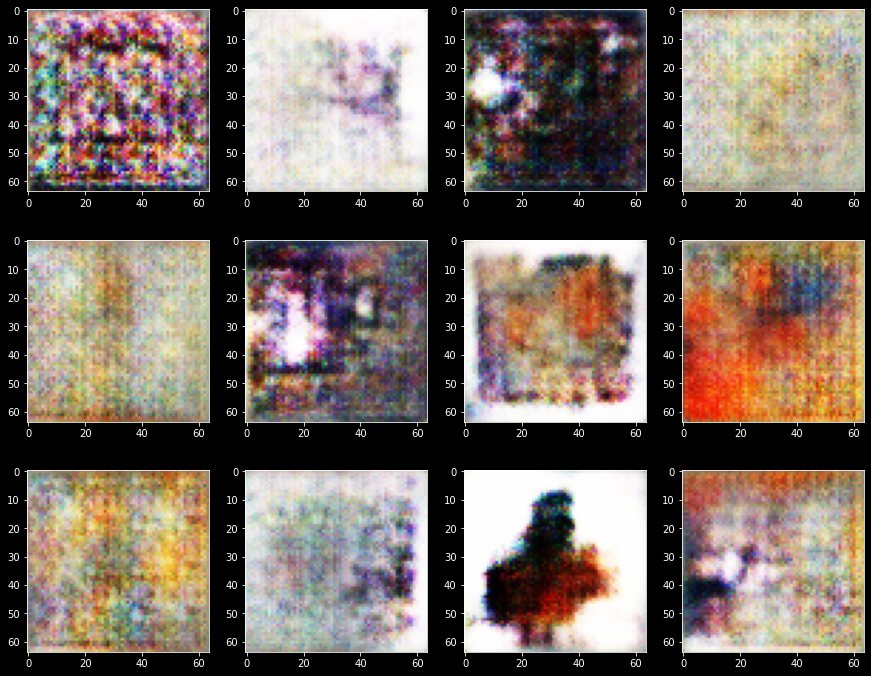

In [22]:
f,ax = plt.subplots(3,4 ,figsize=(15,12))
ax = ax.flatten()
arr = tf.random.normal(shape=(12, LATENT_DIM))
generated_portraits = model.generator(arr)
for i in range(12):
    g=generated_portraits[i]*255
    ax[i].imshow(tf.cast(g,tf.uint8))
    
#it is indeed trying to get new images, but even 777 epochs seem to be not sufficient to create something understandable

In [10]:
from sklearn.cluster import KMeans

images = []
training = tf.keras.preprocessing.image_dataset_from_directory(PATH,label_mode=None ,image_size=IMG_SIZE, batch_size=batch_s).map(lambda x: x / 255.0)
for i,batch in enumerate(training):
    if i == len(training):
        break
    else:
        images.append(np.array(batch[0]))

Found 2782 files belonging to 1 classes.


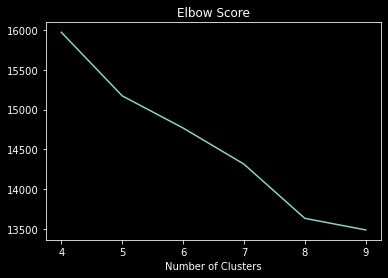

In [11]:
images = np.asarray(images)
images = np.mean(images,axis=3)
images = images.reshape((images.shape[0],-1))

elbow_scores=[]
for c in range(4,10):
    kmeans = KMeans(c)
    kmeans.fit(images[:500])
    elbow_scores.append(kmeans.inertia_)

plt.plot(range(4,10),elbow_scores)
plt.xlabel('Number of Clusters')
plt.title('Elbow Score')
plt.show()

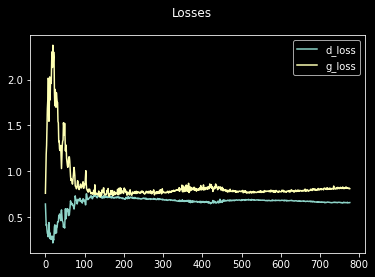

In [12]:
plt.suptitle('Losses')
plt.plot(history.history['d_loss'], label='d_loss')
plt.plot(history.history['g_loss'], label='g_loss')
plt.legend()
#There is no interest to continue testing, if losses will converge to the same rate of 0.75

## NDB Scoring

The ideal GAN should learn a probability distribution that closely mimics the training data distribution. A new metric was introduced to evaluate a GAN failure case known as mode collapse - when the model fails to generate diverse enough outputs.

In [13]:
kmeans=KMeans(7)
train_classes=kmeans.fit_predict(images[:500])

arr = tf.random.normal(shape=(500,LATENT_DIM))
generated_portraits = generator_ganz(arr)
generated_portraits = np.array(generated_portraits).mean(axis=3).reshape((generated_portraits.shape[0],-1))
generated_classes = kmeans.predict(generated_portraits)

In [14]:
def ndb_score(training_data_classes,generated_data_classes,num_classes,z_threshold):
    ndb = []
    NT = len(training_data_classes)
    NG = len(generated_data_classes)
    for i in range(num_classes):
        nt = np.sum(training_data_classes==i)
        pt = nt/len(training_data_classes) #training data proportion for bin
        ng = np.sum(generated_data_classes==i)
        pg = ng/len(generated_data_classes) #generated data proportion for bin
        P = (nt+ng)/(NT+NG)
        SE = (P*(1-P)*((1/NT)+(1/NG)))**0.5
        if abs((pt-pg)/SE) > z_threshold:
            ndb.append(i)
    print('______________________________________')        
    print(f"Statistically different classes:{ndb}")
    print(f"NDB score: {len(ndb)/num_classes}")
    print('______________________________________')
    
ndb_score(train_classes,generated_classes,8,1.96)

______________________________________
Statistically different classes:[3, 4]
NDB score: 0.25
______________________________________


## Conclusion
---
This particular GANs has an NDB score of 0.25 and only two clusters [3,4], which seem to be statistically different from the real distribution.

---
The same way, from artistic point of view, the art created by this GANs may be considered as Abstract, because 

###### Abstract art uses visual language of shape, form, color and line to create a composition which may exist with a degree of independence from visual references in the world

According to Rudolph Arnheim.
On the logical spectrum, This model is far from being perfect and may be upgraded either by adding epochs, optimizing hyperparameters or changing/adding layers.
